# Customer Churn Prediction using Python

### Introduction 

#### In this notebook, I’m going to explain step by step how I built a churn prediction model. I’ll say why I did each step — in my own way — so I can explain it confidently in an interview.


# Import libraries

#### Before starting, I imported all the libraries I need for analysis. I used pandas and numpy to handle and clean data, seaborn and matplotlib to explore and visualize it, and sklearn modules to preprocess data, build models, and evaluate their performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Load & inspect data

#### Here, I loaded the CSV file into a pandas DataFrame and quickly checked the data shape and first few rows. This helps me see what columns are there, understand what the data looks like, and plan the next steps for cleaning and analysis.



In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print("Data shape:", df.shape)
df.head()

Data shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data cleaning

#### In this part, I checked for missing values and found that the TotalCharges column had some non-numeric entries. I converted it to numeric, forcing invalid ones to NaN, then filled those missing values with the column mean so I don’t lose data. Finally, I dropped the customerID column since it doesn’t help prediction. This prepares the dataset for modeling.

In [5]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


#### Convert TotalCharges to numeric (may have spaces or missing values)

In [23]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


#### Fill missing TotalCharges with mean

In [27]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())


#### Drop customerID (not useful for prediction)

In [29]:
df.drop('customerID', axis=1, inplace=True)

In [31]:
print("\nData types after cleaning:")
print(df.dtypes)


Data types after cleaning:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


# Exploratory Data Analysis (EDA)

####  Now, I did EDA to explore patterns visually. I plotted a countplot to see how many customers churned, a boxplot to check if customers paying higher monthly charges are more likely to churn, and a barplot to see churn by contract type. These visualizations help me spot relationships and think about which features may affect churn.


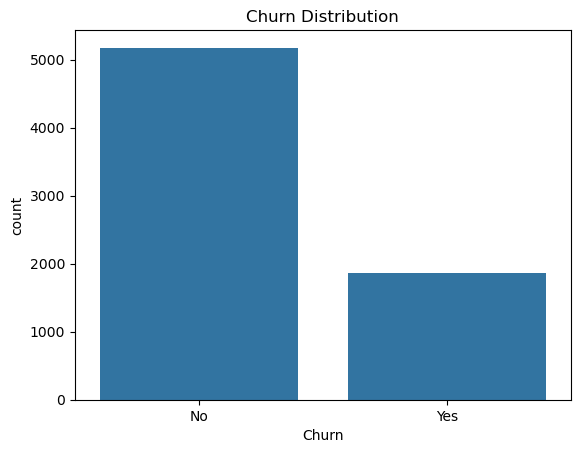

In [33]:
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()


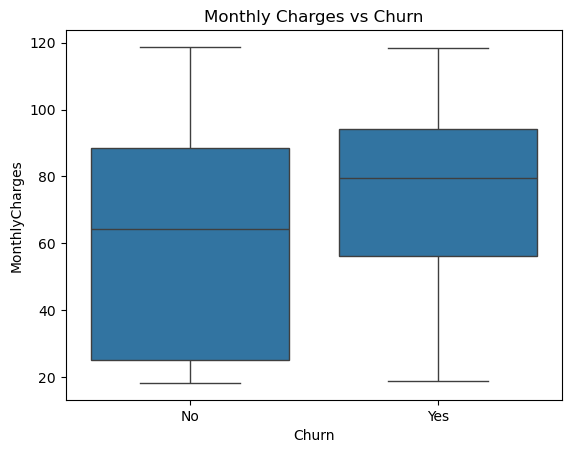

In [35]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.show()

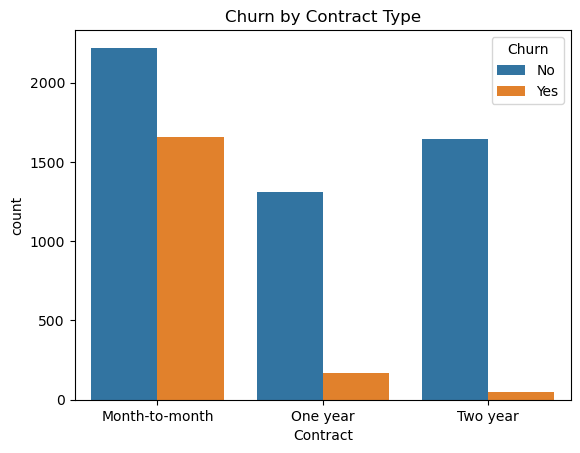

In [37]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.show()

# Encode categorical variables & scale numerics

#### Since machine learning models need numbers, I converted all categorical columns (except the target) to numeric using LabelEncoder. I also converted the target Churn column to 1 and 0. Then, I scaled numeric columns like MonthlyCharges and TotalCharges so features stay on a similar scale, helping models like Logistic Regression perform better.

#### Encode categorical features (except target 'Churn')

In [39]:
for col in df.select_dtypes(include='object').columns:
    if col != 'Churn':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])


#### Encode target variable

In [41]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})


#### Scale numerical features

In [43]:
scaler = StandardScaler()
df[['MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['MonthlyCharges', 'TotalCharges']])

# Build model

#### In this step, I split the data into training and testing sets to evaluate performance fairly. Then, I created a Logistic Regression model, trained it on the training data, and used it to predict churn on the test data. This builds my first baseline predictive model.


In [45]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate model

### In this step, I evaluated how well my model predicts churn. First, I calculated the accuracy score, which tells me what percentage of my test data was correctly predicted. Then, I plotted the confusion matrix to clearly see how many true positives, true negatives, false positives, and false negatives the model produced, this helps me know where my model is making mistakes. Next, I printed the full classification report which shows precision, recall, and F1-score for both churn and no-churn classes. Finally, I plotted the ROC curve and calculated the ROC-AUC score to check how well my model separates churners from non-churners. This full evaluation gives me clear evidence about my model’s strengths and weaknesses, which I can confidently explain in the interview.


In [47]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.8161816891412349


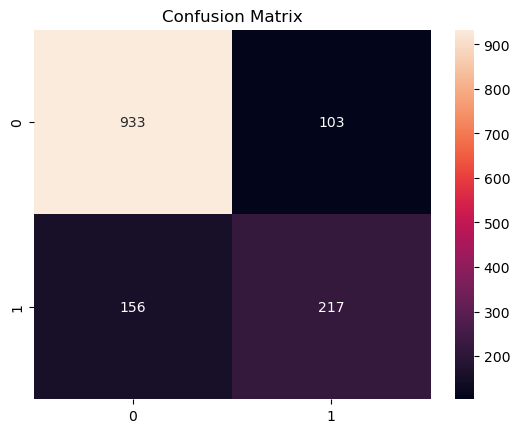

In [49]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



# ROC-AUC

In [53]:
y_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.8613985011438093


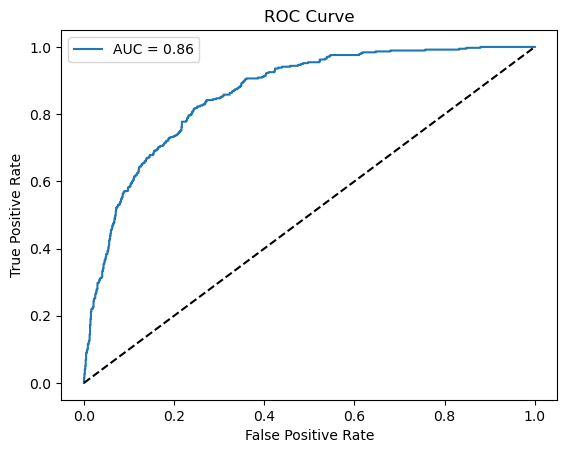

In [55]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Bonus : Random Forest feature importance

#### To dig deeper, I trained a Random Forest model. This not only gives another prediction, but also shows which features were most important for predicting churn. Then, I compared its accuracy to Logistic Regression to check which model performs better.

In [57]:
from sklearn.ensemble import RandomForestClassifier


In [59]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

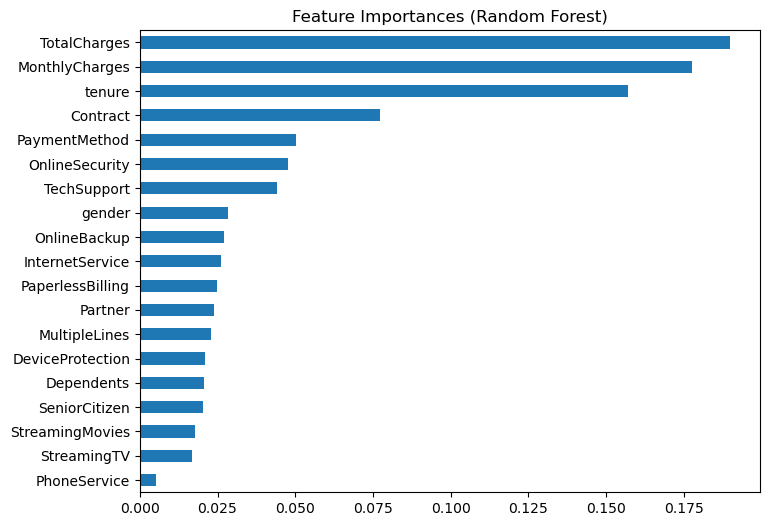

In [61]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title('Feature Importances (Random Forest)')
plt.show()

In [63]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.7920511000709723


## Finally, I cleaned and explored the data, encoded and scaled features, built two models, evaluated them, and found which features impact churn most. 